In [1]:
"""
The following code implements a MobileNet model, that detects whether a depicted driver
is either driving safely or in a distracted manner. 

It uses the Statefarm Distracted Driver dataset for training/testing, and was originally
written by Satya Naren for the Statefarm Kaggle Competition in 2019. 

Extensions, cleaning, and comments for clarity have been added by Fiona LeClair-Robertson for the 
CISC 452 Final project. 

Updated date: 2022-12-03
Authors: Satya Naren and Fiona LeClair-Robertson
Student ID: 20163405
"""
import warnings 
warnings.filterwarnings('ignore')

In [2]:
"""
Importing the necesarry packages to build model using tensorflow/keras.
"""
import os
import random
import numpy as np
import pandas as pd 
from skimage import io
from skimage import color
from PIL import Image
import PIL.Image
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from dask.array.image import imread
from dask import bag, threaded
from dask.diagnostics import ProgressBar
import cv2
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")



from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import imagenet_utils
from keras.layers import Dense,GlobalAveragePooling2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
from IPython.display import Image


import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,Input
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image 
from tensorflow.keras.layers import BatchNormalization
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Model
from keras import optimizers


In [3]:
import os
os.getcwd()

'C:\\Users\\fiona'

In [5]:
"""
Reading in the image list file driectly from local file location on my computer.
"""
driver_details = pd.read_csv('C:/Users/fiona/Downloads/state-farm-distracted-driver-detection/driver_imgs_list.csv',na_values='na')
print(driver_details.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [6]:
## Getting all the images

"""Creating an array to store all the training images and another for its corresponding label."""
train_image = []
image_label = []


"""We have 10 different folders to iterate through for each of the 10 categories 
respectively; 1) Safe driving, 2) texting right, 3) talking on phone right, 4) texting left,
5) talking on the phone left, 6) operating the radio, 7) drinking, 8) reaching behind, 9) hair/makeup,
10) talking to passenger."""

for i in range(10):
    """Indicating which folder /10 we are in."""
    print('now we are in the folder C', i)
    imgs = os.listdir("C:/Users/fiona/Downloads/state-farm-distracted-driver-detection/imgs/train/c"+str(i))
    
    """"""
    for j in range(len(imgs)):
        img_name = "C:/Users/fiona/Downloads/state-farm-distracted-driver-detection/imgs/train/c"+str(i)+"/"+imgs[j]
        img = cv2.imread(img_name)
        img = img[50:,120:-50]
        """Resizing image to 224 x 244 to reduce training time"""
        img = cv2.resize(img,(224,224))
        label = i
        driver = driver_details[driver_details['img'] == imgs[j]]['subject'].values[0]
        train_image.append([img,label,driver])
        image_label.append(i)





now we are in the folder C 0
now we are in the folder C 1
now we are in the folder C 2
now we are in the folder C 3
now we are in the folder C 4
now we are in the folder C 5
now we are in the folder C 6
now we are in the folder C 7
now we are in the folder C 8
now we are in the folder C 9


In [7]:
"""Shuffling the images so that there are different depicted scenarios next to each other."""
import random
random.shuffle(train_image)

In [8]:
"""These are the selected driver IDs."""
driv_selected = ['p050', 'p015', 'p022', 'p056']

In [9]:
"""Creating the training and testing datasets."""
X_train= []
y_train = []
X_test = []
y_test = []
D_train = []
D_test = []

"""Iterating throguh images and appending to our created lists."""
for features,labels,drivers in train_image:
    """Appending selected images to our testing data."""
    if drivers in driv_selected:
        X_test.append(features)
        y_test.append(labels)
        D_test.append(drivers)
    
    else:
        """Appending non selected images to train data."""
        X_train.append(features)
        y_train.append(labels)
        D_train.append(drivers)

"""Printing size of both sets to ensure properly split."""
print (len(X_train),len(X_test))
print (len(y_train),len(y_test))

18732 3692
18732 3692


In [10]:
## Converting images to nparray. Encoding the Y
"""Converting each image to a np array to create our feature maps by filtering the image 3 times."""
X_train = np.array(X_train).reshape(-1,224,224,3)
X_test = np.array(X_test).reshape(-1,224,224,3)
"""Assigning training and testing images a category from c0-c9."""
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

"""Displaying resized shape of training data images."""
print (X_train.shape)

(18732, 224, 224, 3)


# Model

In [17]:
"""The following line of codes imports the model itself, and sets the last top layer of 1000 neurons to false - will not use."""
base_model=MobileNet(weights='imagenet',include_top=False)

In [20]:
x=base_model.output
"""Reduces dimensionality by pooling data by taking the average of each specified block of our feature map."""
x=GlobalAveragePooling2D()(x)

"""First hidden layer in the network using relu activation function."""
x=Dense(1024,activation='relu')(x)
x = Dropout(0.2)(x)  

"""Added this second hidden layer in the network using relu activation function to determine more patterns/improve results.
    I Normalized the data values to reduce duplicates/make network more efficient.
    I added dropout parameters to avoid overfitting."""
x=Dense(1024,activation='relu')(x) 
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

"""Added third hidden layer in the network using relu activation function again."""
x=Dense(512,activation='relu')(x) 

"""Adding final top layer with softmax activation."""
preds=Dense(10,activation='softmax')(x)

"""Giving overview on created model."""
model = Model(inputs=base_model.input, outputs=preds)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 conv1 (Conv2D)              (None, None, None, 32)    864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, None, None, 32)   128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, None, None, 32)    0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, None, None, 32)   288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, None, None, 32)   128       
 ation)                                                    

In [21]:
from keras import optimizers 
"""Selected a learning rate of 0.005 as 0.001 did not converge and larger values led to a decreased accuracy."""
sgd = optimizers.SGD(lr = 0.005) 
"""Using stochastic gradient descent for optimization, cross entropy for loss, and focusing on accruacy as our
validation metric."""
model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy']) # create object


In [22]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping

"""This line of code saves each iteration where the best historical performance of val_loss is outperformed."""
checkpointer = ModelCheckpoint('mobilenet_sgd_nolayers.hdf5', verbose=1, save_best_only=True)

"""This line of code checks to intervene and early stop epoch if the val_loss does not improve for 20 iterations.
    I changed this from the initial value as we are prioritizing accuracy and letting the val_loss decrease slightly 
    for imporved accuracy was a tradeoff I decided to take."""
earlystopper = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

"""Creating new rotated images for more image training data."""
datagen = ImageDataGenerator(
    height_shift_range=0.5,
    width_shift_range = 0.5,
    zoom_range = 0.5,
    rotation_range=30
        )

"""Setting batch size to 64, with 292 batches of 64 total."""
data_generator = datagen.flow(X_train, y_train, batch_size = 64)

"""Fitting model with new created augmented data.
    I set the number of epochs to 30 - in retrospect if I were to train again would likely set to 22 or 23 as
    the accuracy was high with less of a val_loss tradeoff due to overtraining."""
mobilenet_model = model.fit_generator(data_generator,steps_per_epoch = len(X_train) / 64, callbacks=[checkpointer, earlystopper],
                                                            epochs = 30, verbose = 1, validation_data = (X_test, y_test))


Epoch 1/30
293/292 [==============================] - ETA: -1s - loss: 2.1050 - accuracy: 0.2695
Epoch 1: val_loss improved from inf to 1.24732, saving model to mobilenet_sgd_nolayers.hdf5
292/292 [==============================] - 1340s 5s/step - loss: 2.1050 - accuracy: 0.2695 - val_loss: 1.2473 - val_accuracy: 0.5826
Epoch 2/30
293/292 [==============================] - ETA: -1s - loss: 1.2182 - accuracy: 0.5801
Epoch 2: val_loss improved from 1.24732 to 0.57860, saving model to mobilenet_sgd_nolayers.hdf5
292/292 [==============================] - 1439s 5s/step - loss: 1.2182 - accuracy: 0.5801 - val_loss: 0.5786 - val_accuracy: 0.7952
Epoch 3/30
293/292 [==============================] - ETA: -1s - loss: 0.8841 - accuracy: 0.6953
Epoch 3: val_loss improved from 0.57860 to 0.53651, saving model to mobilenet_sgd_nolayers.hdf5
292/292 [==============================] - 1424s 5s/step - loss: 0.8841 - accuracy: 0.6953 - val_loss: 0.5365 - val_accuracy: 0.8077
Epoch 4/30
293/292 [======

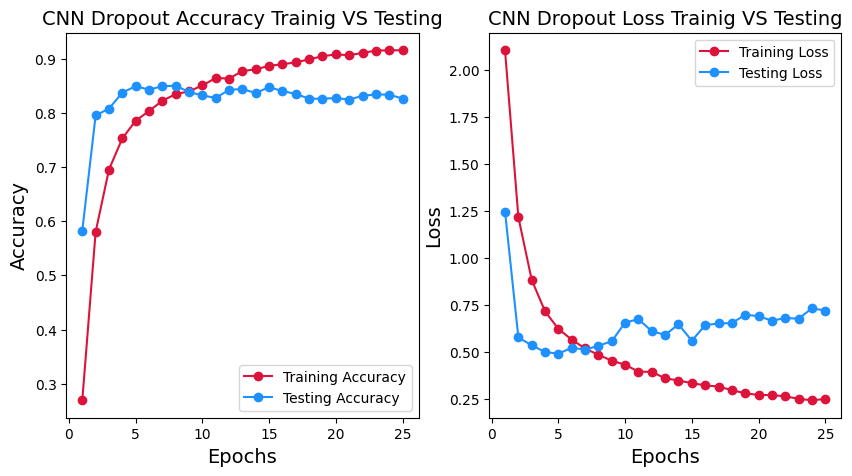

In [28]:
"""The following lines of code are simply for demonstrating training results using a graph."""
fig, axes = plt.subplots(1, 2, figsize = (10, 5))
axes[0].plot(range(1, len(model.history.history['accuracy']) + 1), model.history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Accuracy')
axes[0].plot(range(1, len(model.history.history['val_accuracy']) + 1), model.history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Accuracy')
axes[0].set_xlabel('Epochs', fontsize = 14)
axes[0].set_ylabel('Accuracy',fontsize = 14)
axes[0].set_title('CNN Dropout Accuracy Trainig VS Testing', fontsize = 14)
axes[0].legend(loc = 'best')
axes[1].plot(range(1, len(model.history.history['loss']) + 1), model.history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Training Loss')
axes[1].plot(range(1, len(model.history.history['val_loss']) + 1), model.history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Testing Loss')
axes[1].set_xlabel('Epochs', fontsize = 14)
axes[1].set_ylabel('Loss',fontsize = 14)
axes[1].set_title('CNN Dropout Loss Trainig VS Testing', fontsize = 14)
axes[1].legend(loc = 'best')